# Simple CNN on dataset

In [15]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras import backend as K
from keras.utils import multi_gpu_model


In [16]:
# dimensions of our images.
img_width, img_height = 224, 224

train_data_dir = '../dataset/train'
validation_data_dir = '../dataset/test'
nb_train_samples = 194
nb_validation_samples = 49
epochs = 50
batch_size = 4

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)


In [23]:
from keras.applications.resnet import ResNet50
import numpy as np

base_model = ResNet50(weights='imagenet', input_shape=(img_width, img_height, 3), include_top = False, pooling='max')

#adam = keras.optimizers.Adam(lr=1e-4)
#model.compile(loss='binary_crossentropy',
#              optimizer=adam,
#              metrics=['accuracy'])

x = base_model.output
# x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


adam = keras.optimizers.Adam(lr=1e-4)
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

model.summary()


94773248/94765736 [==============================] - 11s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_________________________

In [24]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    samplewise_center=True,
    samplewise_std_normalization=True,
    brightness_range=(0.1, 0.9))

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255, samplewise_center=True,
    samplewise_std_normalization=True,)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')



Found 193 images belonging to 2 classes.
Found 49 images belonging to 2 classes.


In [25]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
48/48 [==============================] - 40s 829ms/step - loss: 0.7163 - acc: 0.5988 - val_loss: 1.1285 - val_acc: 0.6042
Epoch 2/50
48/48 [==============================] - 29s 598ms/step - loss: 0.6657 - acc: 0.6718 - val_loss: 1.1587 - val_acc: 0.5778
Epoch 3/50
48/48 [==============================] - 29s 596ms/step - loss: 0.5581 - acc: 0.7291 - val_loss: 0.6846 - val_acc: 0.7333
Epoch 4/50
48/48 [==============================] - 28s 590ms/step - loss: 0.4439 - acc: 0.7659 - val_loss: 0.8754 - val_acc: 0.6889
Epoch 5/50
48/48 [==============================] - 28s 580ms/step - loss: 0.3797 - acc: 0.8023 - val_loss: 1.7015 - val_acc: 0.6444
Epoch 6/50
48/48 [==============================] - 28s 577ms/step - loss: 0.4168 - acc: 0.8073 - val_loss: 1.0582 - val_acc: 0.6889
Epoch 7/50
48/48 [==============================] - 27s 561ms/step - loss: 0.2777 - acc: 0.8854 - val_loss: 0.8164 - val_acc: 0.6889
Epoch 8/50
48/48 [==============================] - 27s 552ms/step - 

In [26]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

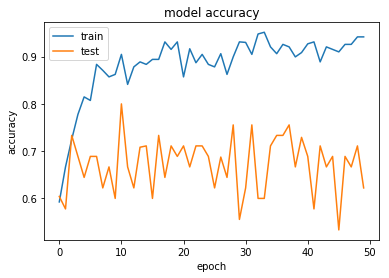

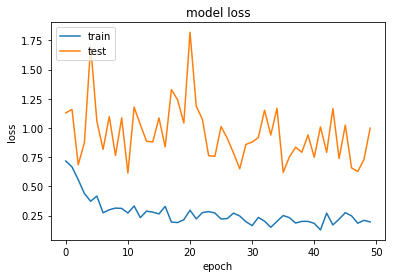

In [27]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        samplewise_center=True,
        samplewise_std_normalization=True,
        brightness_range=(0.1, 0.9))

img = load_img('../datasets/train/N/1_30_1_231.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/train/N/1_30_1_231.jpg'

In [ ]:
x_train = []
for i in range(25):
    x_batch, y_batch = next(train_generator)
    x_train.append(x_batch)
    
x_test = []
for i in range(2):
    x_batch, y_batch = next(validation_generator)
    x_test.append(x_batch)
    

In [ ]:
img = load_img('../dataset/test/N/1_30_2_382.JPG')  # this is a PIL image
plt.imshow(img)

In [ ]:
imgNames = os.listdir('../dataset/test/N')
for img in imgNames: 
    print("HERE")
    imgname = '../dataset/test/N/' + img; 
    myimg = load_img(imgname)  # this is a PIL image
    plt.imshow(myimg)
    plt.show()

In [38]:
x_train = np.concatenate(x_train)
x_train.shape

x_test = np.concatenate(x_test)
x_test.shape

(94, 300, 300, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


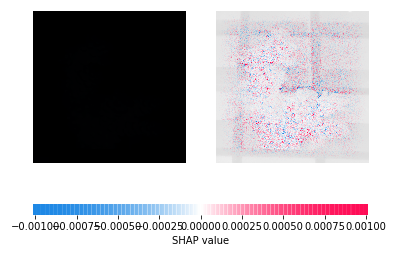

In [39]:
import shap
import numpy as np

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 10, replace=True)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:2])

# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:2])

In [40]:
x_test[1]

array([[[ 0.45964733,  0.45964733, -0.07898695],
        [ 0.43720424,  0.43720424, -0.10143004],
        [ 0.36987495,  0.36987495, -0.16875933],
        ...,
        [ 0.43720424,  0.39231804, -0.12387314],
        [ 0.45964733,  0.41476116, -0.10143004],
        [ 0.5494197 ,  0.43720424, -0.05654386]],

       [[ 0.45964733,  0.45964733, -0.07898695],
        [ 0.43720424,  0.43720424, -0.10143004],
        [ 0.43720424,  0.43720424, -0.10143004],
        ...,
        [ 0.45964733,  0.41476116, -0.10143004],
        [ 0.41476116,  0.36987495, -0.19120243],
        [ 0.52697664,  0.43720424, -0.12387314]],

       [[ 0.39231804,  0.39231804, -0.14631623],
        [ 0.36987495,  0.36987495, -0.16875933],
        [ 0.41476116,  0.41476116, -0.16875933],
        ...,
        [ 0.45964733,  0.41476116, -0.14631623],
        [ 0.5045335 ,  0.45964733, -0.10143004],
        [ 0.48209044,  0.39231804, -0.16875933]],

       ...,

       [[-0.41563338, -0.46051958, -0.9767109 ],
        [-0